# Function to fit our analytical model to the SF-gas from TNG

Our fit procedure is also described in section 3 of van son et al in prep.




In [225]:
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from scipy import interpolate
from scipy.optimize import minimize

# from astropy.cosmology import WMAP9, z_at_value
from astropy.cosmology import Planck18  as cosmo# Planck 2018
from astropy.cosmology import z_at_value

############################
# Custom scripts
import get_ZdepSFRD as Z_SFRD
import importlib
import paths

Cosmol_sim_location = paths.data / "SFRMetallicityFromGasTNG100.hdf5"


# First read the data that you want to fit to
***
We will have simulation data == TNG in our case
Make sure to convert it to a SFDR in Msun/yr/Mpc^-3

model data  == our analytical function

## Make sure you provide at least:

- Sim_SFRD = SFRD(z,Z)/($\Delta$Z), in $\rm{M}_{\odot} \rm{Mpc}^{-3}$
- MetalBins, in metallicity $Z$
- Lookbacktimes, in $\rm{Gyr}$

It is important that you provide the SFRD per dZ bin!! Otherwise your fit will be bin dependent, which is not what you want.. 



In [239]:
##########################################
# Observational (Chruslinska data)
##########################################
def solar_metallicity_scales():
    Asplund09=[0.0134,8.69]
    AndersGrevesse89=[0.017,8.83]
    GrevesseSauval98=[0.0201,8.93]
    Villante14=[0.019,8.85]
    scale_ref=np.array(['Asplund09','AndersGrevesse89','GrevesseSauval98','Villante14'])
    Z_FOH_solar=np.array([Asplund09,AndersGrevesse89,GrevesseSauval98,Villante14])
    return scale_ref, Z_FOH_solar


##########################
def FOH2ZZ(foh,solar_Z_scale='AndersGrevesse89'):
    '''convert from 12+log[O/H] to ZZ'''
    scale_ref, Z_FOH_solar=solar_metallicity_scales()
    idx=np.where(scale_ref==solar_Z_scale)[0][0]
    Zsun,FOHsun = Z_FOH_solar[idx]    
    logZ = np.log10(Zsun) + foh - FOHsun
    ZZ=10**logZ
    return ZZ


#read low Z data
low_Z_file = '204'+ 'f14SB'+'Boco'+ '_FMR270'+ '_FOH_z_dM.dat'

data_dir   = str(paths.data)+'/SFRD_Z_z_data/' 
zmin, zmax = 0., 10.

#(array) oxygen to hydrogen abundance ratio ( FOH == 12 + log(O/H) )
# as used in the calculations - do not change
FOH_min, FOH_max = 5.3, 9.7
FOH_arr = np.linspace( FOH_min,FOH_max, 200)
dFOH=FOH_arr[1]-FOH_arr[0]

#read time, redshift and timestep as used in the calculations
#starts at the highest redshift (z=z_start=10) and goes to z=0
time, redshift_global, delt = np.loadtxt(data_dir +'Time_redshift_deltaT.dat',unpack=True) 
#reading mass per unit (comoving) volume formed in each z (row) - FOH (column) bin
data=np.loadtxt(data_dir + low_Z_file )
image_data=np.array( [data[ii]/(1e6*delt[ii]) for ii in range(len(delt))] )#fill the array with SFRD(FOH,z)
redshift=redshift_global

image_data/=dFOH

# np.log10(Z_array/ZsunTNG), lowZ_image[min_diff_i,:] ,
# lowZ_image, redshift, delt 

Sim_center_Zbin  = FOH2ZZ(FOH_arr,solar_Z_scale='AndersGrevesse89')
Lookbacktimes    = [cosmo.lookback_time(z).value for z in redshift]
Sim_SFRD         = image_data


# print('MetalBins', np.log10(MetalBins))


In [201]:
##########################################
# Simulated SFRD data (from TNG)
##########################################
## Read in the pure simulation data
with h5.File(Cosmol_sim_location, "r") as f:
    MetalBins     = f["MetalBins"][:]
    Lookbacktimes = f["Lookbacktimes"][:]
    BoxSfr        = f["Sfr"][:]
    
Sim_center_Zbin  = (MetalBins[:-1] + MetalBins[1:])/2.
    
# Convert SFR from sfr/box to sfr Mpc-3
littleh  = 0.6774
Rbox     = 75/littleh
Sim_SFRD = BoxSfr / Rbox**3 *u.Mpc**-3
Sim_SFRD = Sim_SFRD.value

## The model comes in SFRD/DeltaZ, make sure your data does as well!! 
step_fit_logZ  = np.diff(np.log(MetalBins))[0]    
Sim_SFRD       = Sim_SFRD/step_fit_logZ



### Now we're going to make some cuts 

Because the minimum metallicity in COMPAS is 10^-4, there is no use in fitting to the 10^-7 metallicity tail.

This cuts out the "POP-III" star formation that is happening at 10^-7 in the cosmological simulation. Since we don't capture this kind of stellar evolution in the pop-synth, we don't want to skew our distribution to try and capture that


In [240]:
minZ_popSynth    =  1e-6
## Adjust what metallicities to include 
tofit_Sim_metals = Sim_center_Zbin[np.where(Sim_center_Zbin > minZ_popSynth)[0]]   

## Reverse the time axis of the SFRD and lookback time for the fit
tofit_Sim_SFRD      = Sim_SFRD[:,np.where(Sim_center_Zbin > minZ_popSynth)[0]][::-1]
tofit_Sim_lookbackt = Lookbacktimes[::-1] 

## Convert lookback times to redshifts
# the last value of Lookbacktimes = 0, which is problematic for z calculation
redshifts_Sim = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in Lookbacktimes[:-1]] 
redshifts_Sim.append(0) # put redshift zero back at the end
redshifts_Sim = np.array(redshifts_Sim)


## Interpolate the fit data

To ensure that we have a nice and smooth set to compare to 

Using scipy interpolate
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html

f = interpolate.interp2d(x, y, z)



In [241]:
#########################################
# Interpolate the simulation data
f_interp = interpolate.interp2d(tofit_Sim_lookbackt, tofit_Sim_metals, tofit_Sim_SFRD.T, kind='cubic')

#########################################
# Retrieve values at higher res regular intervals
redshift_new         = np.arange(0, 10.1, 0.05)
Lookbacktimes_new    = [cosmo.lookback_time(z).value for z in redshift_new]

log_tofit_Sim_metals = np.log10(tofit_Sim_metals)
metals_new           = np.logspace(min(log_tofit_Sim_metals), max(log_tofit_Sim_metals), 100)

SFRDnew = f_interp(Lookbacktimes_new,metals_new)


In [242]:
##################################################
# muz =-0.09, mu0 =0.026, sigma =1.9, alpha=-3.3
##################################################
def calc_chi_square(fit_metals, Redshifts = [],  simulation_SFRD = [],
                    mu_0  = 0.026, muz  =-0.09, sigma0  = 1.9, sigmaz  = 1.9, alpha =-3.3,
                    sf_a =0.01 , sf_b=2.6, sf_c=3.2 , sf_d=6.2):
    """
    Calculate the aquared residual of your simulation_SFRD vs your analytical model.
    Args:
        fit_metals        --> [float]          metals used for fitt
        Redshifts         --> [float]          redshihts used to fit
        simulation_SFRD   --> [float]          cosmological simulation data to fit to
        
        # metallicity distribution parameters (skew-log-normal)
        mu_0              --> [float]          location (mean in normal) at redshift 0
        muz               --> [float]          redshift evolution of the location
        sigma0            --> [float]          Scale at redshift 0 (variance in normal)
        sigmaz            --> [float]          redshift evolution of Scale (variance in normal)
        alpha             --> [float]          shape (skewness, alpha = 0 retrieves normal dist)
        # overall SFR parameters
        sf_a              --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_b              --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_c              --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_d              --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)

    Returns:
        tot_chi_square    --> [float ] 

    """ 
    #####################################
    # Get the SFR (Shape of Madau & Fragos 2014)
    sfr = Z_SFRD.Madau_Dickinson2014(Redshifts, a=sf_a, b=sf_b, c=sf_c, d=sf_d).value # Msun year-1 Mpc-3 
    # Get dPdZ (skew-log-normal distribution)
    dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                    Z_SFRD.skew_metallicity_distribution(Redshifts,mu_z = muz , mu_0 = mu_0 ,
                                                  omega_0= sigma0 , omega_z=sigmaz , alpha = alpha , 
                                                  metals=fit_metals)
    
    ######################################
    data           = simulation_SFRD                # Model comes in dP/dlogZ, so should your sim-data 
    model          = sfr[:,np.newaxis] * dPdlogZ 

    # The square of the residuals
    res_squared = ((data - model )**2)
    # Divide over the sum of the model at each redshift,
    # reduces contribution from high sfr redshifts & increases the weight where sfr is low
    chi_square = res_squared/np.sum(model, axis = 1)[:,np.newaxis]
    
    # Return sum Chi_squared and the max squared residual
    return np.sum(chi_square), np.amax(res_squared)


    
    

# Run your chi square calculations

## and leave the refinement up to scipy minimize

In [243]:
#################################################################
## Function wrapper to minimize the Chi_square
#################################################################
def test_chi(x0 = [-0.09, 0.026, 1.9, 0.1, -3.3, 0.01, 2.6, 3.2, 6.2] ):
    chi_square, max_res_square = calc_chi_square(metals_new, Redshifts = redshift_new, simulation_SFRD = SFRDnew.T, 
                                       muz  =x0[0], mu_0  =x0[1],sigma0  =x0[2], sigmaz =x0[3], alpha  =x0[4],
                                       sf_a =x0[5], sf_b=x0[6], sf_c=x0[7], sf_d=x0[8])
    return chi_square

# BEST GUESS
# x0 = np.array([-0.15, 0.026, 1.1, 0.1, -3.3, 0.01, 2.6, 3.2, 6.2])
x0 = np.array([-0.15, 0.026, 1.1, 0.1, -5.3, 0.005, 1., 3, 6])
# FIT
res = minimize(test_chi, x0= x0, method ='nelder-mead',
               options = {'maxiter': 5000}, bounds = bnds)



In [244]:
print(res.success, res.message, 'N iterations: ', res.nit)
muz_best, mu0_best, sigma0_best, sigmaz_best, alpha_best = res.x[0], res.x[1], res.x[2], res.x[3],res.x[4]
sf_a_best, sf_b_best, sf_c_best, sf_d_best               = res.x[5], res.x[6], res.x[7], res.x[8] 

print('\nBEST FITTING PARAMETERS:')
print('muz =%s, mu0 =%s, sigma_0 =%s, sigma_z =%s, alpha=%s'% (muz_best, mu0_best, sigma0_best, sigmaz_best, alpha_best) )
print('sf_a =%s, sf_b =%s, sf_c =%s, sf_d =%s'% (sf_a_best, sf_b_best, sf_c_best, sf_d_best) )

chi_square, max_res_square = calc_chi_square(metals_new, Redshifts = redshift_new, simulation_SFRD = SFRDnew.T, 
                                   muz =muz_best, mu_0 =mu0_best,sigma0 =sigma0_best, sigmaz=sigmaz_best,alpha=alpha_best,
                                   sf_a =sf_a_best, sf_b=sf_b_best, sf_c=sf_c_best, sf_d=sf_d_best)
print('chi_square',chi_square, 'max_res_square', max_res_square)


True Optimization terminated successfully. N iterations:  1393

BEST FITTING PARAMETERS:
muz =-0.04545720706611225, mu0 =0.009521681084746773, sigma_0 =1.0780482975933046, sigma_z =0.039910421760746065, alpha=-5.014746137754878
sf_a =0.01824759583515829, sf_b =2.9086449034344444, sf_c =3.018863115660491, sf_d =5.767052164598724
chi_square 0.23297244261847583 max_res_square 0.0009475744065590888


In [245]:
if res.success:
    np.savetxt(paths.data / 'MartynaLOWZ_best_fit_parameters.txt', #MartynaLOWZ
               np.c_[mu0_best, muz_best, sigma0_best, sigmaz_best, alpha_best,sf_a_best, sf_b_best, sf_c_best, sf_d_best],
               header = "mu0, muz, omega0, omegaz, alpha0,sf_a, sf_b, sf_c, sf_d", delimiter=',', fmt="%s")


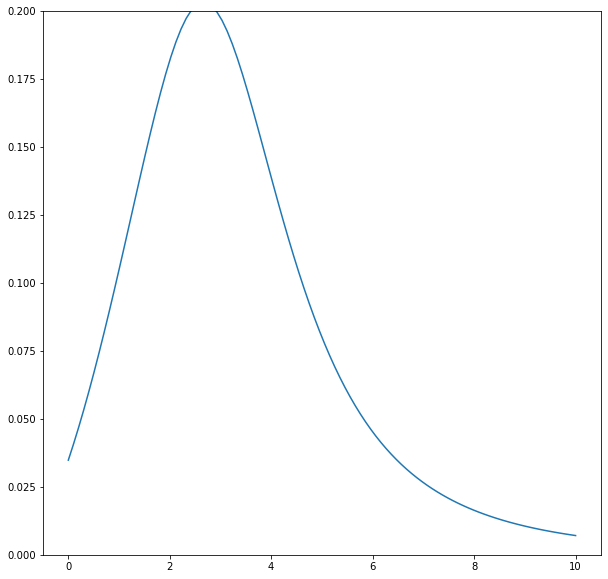

In [187]:
fig, ax = plt.subplots(figsize = (10,10))
Redshifts = np.linspace(0,10, num=100)
test_srd = Z_SFRD.Madau_Dickinson2014(Redshifts, a=sf_a_best, b=sf_b_best, c=sf_c_best, d=sf_d_best).value # Msun year-1 Mpc-3 
plt.ylim(0,0.2)
plt.plot(Redshifts, test_srd)
plt.show()
